### Imports

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pydataset import data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import sktime

import statsmodels as sm


In [74]:
import warnings
warnings.filterwarnings('ignore')

# Section 1- Supervised Learning for Time Series- Data Preprocessing

## Data Preprocessing for Supervised Learning

### Load Data

### Air Quality data set

In [75]:
# Load the Air Quality dataset
air_q_df = data('airquality')
print(air_q_df.head())
print(air_q_df.info())


   Ozone  Solar.R  Wind  Temp  Month  Day
1  41.00   190.00  7.40    67      5    1
2  36.00   118.00  8.00    72      5    2
3  12.00   149.00 12.60    74      5    3
4  18.00   313.00 11.50    62      5    4
5    NaN      NaN 14.30    56      5    5
<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 1 to 153
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ozone    116 non-null    float64
 1   Solar.R  146 non-null    float64
 2   Wind     153 non-null    float64
 3   Temp     153 non-null    int64  
 4   Month    153 non-null    int64  
 5   Day      153 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 8.4 KB
None


#### Clean and set Time index

            Ozone  Solar.R  Wind  Temp
datetime                              
2014-05-01  41.00   190.00  7.40    67
2014-05-02  36.00   118.00  8.00    72
2014-05-03  12.00   149.00 12.60    74
2014-05-04  18.00   313.00 11.50    62
2014-05-07  23.00   299.00  8.60    65
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 111 entries, 2014-05-01 to 2014-09-30
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ozone    111 non-null    float64
 1   Solar.R  111 non-null    float64
 2   Wind     111 non-null    float64
 3   Temp     111 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 4.3 KB
None


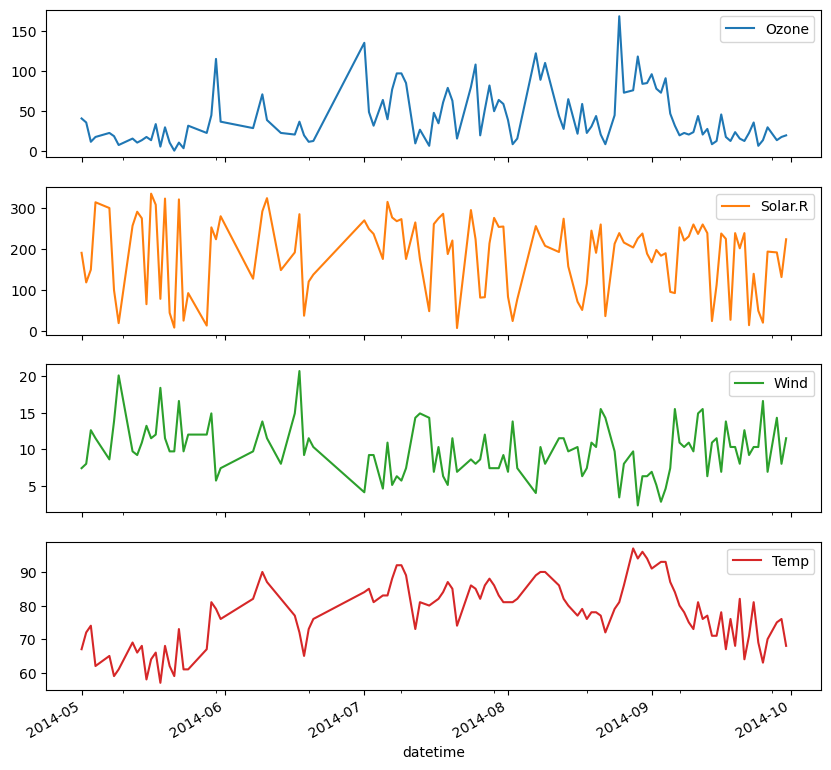

In [76]:
# Set a random year for the datetime index
air_q_df['Year'] = 2014
# Convert the Year, Month, Day columns to a datetime index 
air_q_df['datetime'] = pd.to_datetime(air_q_df[['Year', 'Month', 'Day']])
# Set the datetime column as the index
air_q_df.set_index('datetime', inplace=True)
# Drop the Month, Day columns
air_q_df.drop(columns=['Year','Month', 'Day'], inplace=True)

# Drop any rows with missing values
air_q_df = air_q_df.dropna()

# Display the first few rows of the dataset
print(air_q_df.head())
print(air_q_df.info())

# plot the data
air_q_df.plot(subplots=True,figsize=(10, 10))
#plt.title('Air Quality Data')
plt.show()

### Feature Engineering: Time-Based Features

#### Create Lag Features

In [77]:
# creat copy of the dataframe
features_df = air_q_df.copy()

# Create lag features for Ozone
features_df['Ozone_Lag1'] = features_df['Ozone'].shift(1)
features_df['Ozone_Lag2'] = features_df['Ozone'].shift(2)
features_df['Ozone_Lag7'] = features_df['Ozone'].shift(7) #example of weekly lag


print('\nfeatures_df original shape:', features_df.shape)

# Drop rows with NaN values introduced by shifting
features_df.dropna(inplace=True)
print('\nfeatures_df shape after trimming NaNs:', features_df.shape)
# Display the dataset with lag features
features_df.tail()


features_df original shape: (111, 7)

features_df shape after trimming NaNs: (104, 7)


,Ozone,Solar.R,Wind,Temp,Ozone_Lag1,Ozone_Lag2,Ozone_Lag7
datetime,,,,,,,
2014-09-25,14.00,20.00,16.60,63,7.00,36.00,13.00
2014-09-26,30.00,193.00,6.90,70,14.00,7.00,24.00
2014-09-28,14.00,191.00,14.30,75,30.00,14.00,16.00
2014-09-29,18.00,131.00,8.00,76,14.00,30.00,13.00
2014-09-30,20.00,223.00,11.50,68,18.00,14.00,23.00


#### Function to Create Lag Features

In [78]:
def create_lagged_features(df, window_size, variables=None):
    """
    Create lagged features for specified variables based on a given window size.
    gets the data frame, the variables to create lagged features as list, and the window size
    if variables is None, use all columns in the dataframe
    """
    if variables is None:
        variables = df.columns

    for variable in variables:
        for lag in range(window_size, 0 , -1): # iterate over the window size in reverse
            lagged_col_name = f"{variable}_Lag{lag}"
            df[lagged_col_name] = df[variable].shift(lag)
    
    # Drop rows with NaN values introduced by shifting
    df.dropna(inplace=True)
    
    return df

In [79]:
# creat copy of the dataframe
features_df = air_q_df.copy()
print('features_df original shape:', features_df.shape)

# Create lag features for Ozone
features_df = create_lagged_features(features_df, window_size=3, variables=['Ozone','Wind'])

print('\nfeatures_df shape after trimming NaNs:', features_df.shape)
features_df.head()

features_df original shape: (111, 4)

features_df shape after trimming NaNs: (108, 10)


,Ozone,Solar.R,Wind,Temp,Ozone_Lag3,Ozone_Lag2,Ozone_Lag1,Wind_Lag3,Wind_Lag2,Wind_Lag1
datetime,,,,,,,,,,
2014-05-04,18.00,313.00,11.50,62,41.00,36.00,12.00,7.40,8.00,12.60
2014-05-07,23.00,299.00,8.60,65,36.00,12.00,18.00,8.00,12.60,11.50
2014-05-08,19.00,99.00,13.80,59,12.00,18.00,23.00,12.60,11.50,8.60
2014-05-09,8.00,19.00,20.10,61,18.00,23.00,19.00,11.50,8.60,13.80
2014-05-12,16.00,256.00,9.70,69,23.00,19.00,8.00,8.60,13.80,20.10


#### Rolling Statistics

In [80]:
# creat copy of the dataframe
features_df = air_q_df.copy()
print('features_df original shape:', features_df.shape)

# Create rolling mean features for Ozone and Temp
features_df['Ozone_RollingMean'] = features_df['Ozone'].rolling(window=7).mean()
features_df['Temp_RollingMean'] = features_df['Temp'].rolling(window=7).mean()

# Create rolling std features for Ozone and Temp
features_df['Ozone_RollingStd'] = features_df['Ozone'].rolling(window=7).std()
features_df['Temp_RollingStd'] = features_df['Temp'].rolling(window=7).std()

# Drop rows with NaN values introduced by rolling mean calculation
features_df.dropna(inplace=True)
print('\nfeatures_df shape after trimming NaNs:', features_df.shape)

# Display the dataset with rolling statistics
# show only 1 decimal places
pd.set_option('display.float_format', '{:.1f}'.format)
features_df[['Ozone','Temp','Ozone_RollingMean','Temp_RollingMean','Ozone_RollingStd','Temp_RollingStd']].tail(7)


features_df original shape: (111, 4)

features_df shape after trimming NaNs: (105, 8)


,Ozone,Temp,Ozone_RollingMean,Temp_RollingMean,Ozone_RollingStd,Temp_RollingStd
datetime,,,,,,
2014-09-23,36.0,81,20.4,72.7,8.1,7.1
2014-09-24,7.0,69,18.9,73.0,9.6,6.8
2014-09-25,14.0,63,19.0,71.1,9.5,7.6
2014-09-26,30.0,70,19.9,71.4,10.3,7.5
2014-09-28,14.0,75,19.6,70.4,10.4,6.2
2014-09-29,18.0,76,20.3,72.1,10.1,5.8
2014-09-30,20.0,68,19.9,71.7,10.0,6.0


#### Calander / Seasonal Components

In [81]:
# creat copy of the dataframe
features_df = air_q_df.copy()

# encode the Day of the week in a column
features_df['Day_of_Week'] = features_df.index.dayofweek
# encode the Month in a column
features_df['Month'] = features_df.index.month
# show only 1 decimal places
pd.set_option('display.float_format', '{:.1f}'.format)
features_df.tail()

,Ozone,Solar.R,Wind,Temp,Day_of_Week,Month
datetime,,,,,,
2014-09-25,14.0,20.0,16.6,63,3,9
2014-09-26,30.0,193.0,6.9,70,4,9
2014-09-28,14.0,191.0,14.3,75,6,9
2014-09-29,18.0,131.0,8.0,76,0,9
2014-09-30,20.0,223.0,11.5,68,1,9


#### One-Hot Encoding (when it is not an ordinal parameter and we don't want to introduce false order)

In [82]:
# creat one-hot encoding for the Day of the week 
features_df = pd.get_dummies(features_df, columns=['Day_of_Week'], drop_first=False)

features_df.head()

,Ozone,Solar.R,Wind,Temp,Month,Day_of_Week_0,Day_of_Week_1,Day_of_Week_2,Day_of_Week_3,Day_of_Week_4,Day_of_Week_5,Day_of_Week_6
datetime,,,,,,,,,,,,
2014-05-01,41.0,190.0,7.4,67,5,False,False,False,True,False,False,False
2014-05-02,36.0,118.0,8.0,72,5,False,False,False,False,True,False,False
2014-05-03,12.0,149.0,12.6,74,5,False,False,False,False,False,True,False
2014-05-04,18.0,313.0,11.5,62,5,False,False,False,False,False,False,True
2014-05-07,23.0,299.0,8.6,65,5,False,False,True,False,False,False,False


### Scaling Transformation 

array([<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>], dtype=object)

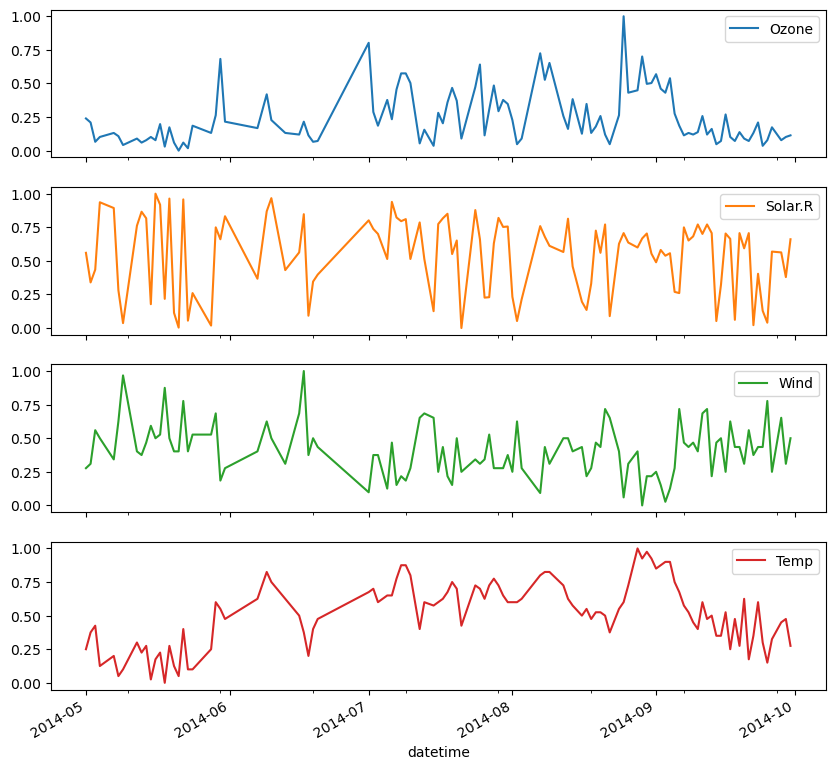

In [83]:
# creat copy of the dataframe
features_df = air_q_df.copy()

# Initialize the scaler
scaler = MinMaxScaler() # default=(0, 1)
# scaler = StandardScaler()

# Save aside the time index
time_index = features_df.index

# save the column names
column_names = features_df.columns

# Apply scaling to the entire dataset
features_df_scaled = scaler.fit_transform(features_df) # returns a np array

# Convert the scaled np array back to a DataFrame
features_df_scaled = pd.DataFrame(features_df_scaled, columns=column_names)

# Set back the time index
features_df_scaled.set_index(time_index, inplace=True)

# Display the scaled dataset
pd.set_option('display.float_format', '{:.2f}'.format)
features_df_scaled.plot(subplots=True, figsize=(10, 10))

## Time Series ML Regression Models - Scikit-learn

### load data

number of missing values: Total Energy Consumed by the Residential Sector    0
dtype: int64
(588, 1)
Index(['Total Energy Consumed by the Residential Sector'], dtype='object')
Index(['E_consumption'], dtype='object')


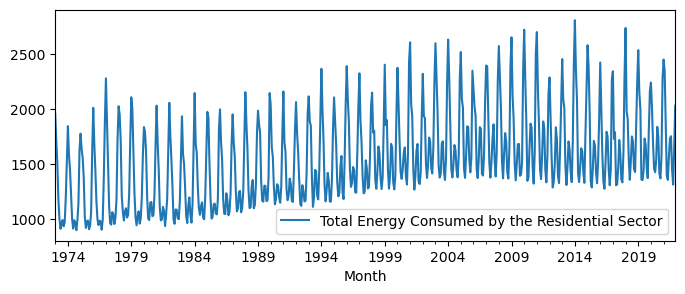

In [84]:
energy = pd.read_csv('Data_sets/energy_consumption.csv', index_col='Month',parse_dates=True)
energy.index.freq = 'MS' # set the frequency of the data to Month Start
#energy.columns = ['y']
energy.plot(figsize=(8, 3))

print('number of missing values:', energy.isna().sum())
print(energy.shape)
print(energy.columns)
#replace column name to E_consumption
energy.rename(columns={'Total Energy Consumed by the Residential Sector':'E_consumption'}, inplace=True)
print(energy.columns)


### Feature engineering

#### Crate laged features

In [85]:
# a function to create laged features for a one-step forecast model
def create_lag_features(df, target_variable, lags):
    dfproccess=df.copy()
    for lag in range(1,lags+1):
        dfproccess[f'Lag{lag}'] = dfproccess[target_variable].shift(lag)
    dfproccess.dropna(inplace=True)
    return dfproccess


In [86]:
energy_lags = create_lag_features(energy,'E_consumption', 12)
energy_lags

,E_consumption,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,Lag10,Lag11,Lag12
Month,,,,,,,,,,,,,
1974-01-01,1846.93,1538.57,1202.11,978.16,937.08,994.26,961.87,914.95,1006.33,1183.42,1510.08,1712.14,1957.64
1974-02-01,1589.45,1846.93,1538.57,1202.11,978.16,937.08,994.26,961.87,914.95,1006.33,1183.42,1510.08,1712.14
1974-03-01,1451.07,1589.45,1846.93,1538.57,1202.11,978.16,937.08,994.26,961.87,914.95,1006.33,1183.42,1510.08
1974-04-01,1215.23,1451.07,1589.45,1846.93,1538.57,1202.11,978.16,937.08,994.26,961.87,914.95,1006.33,1183.42
1974-05-01,1003.82,1215.23,1451.07,1589.45,1846.93,1538.57,1202.11,978.16,937.08,994.26,961.87,914.95,1006.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,1755.21,1737.44,1564.20,1358.57,1397.14,1856.03,2350.98,2451.10,2274.28,1567.71,1372.20,1419.17,1750.27
2021-09-01,1456.90,1755.21,1737.44,1564.20,1358.57,1397.14,1856.03,2350.98,2451.10,2274.28,1567.71,1372.20,1419.17
2021-10-01,1315.80,1456.90,1755.21,1737.44,1564.20,1358.57,1397.14,1856.03,2350.98,2451.10,2274.28,1567.71,1372.20


#### Calendar / Seasonal Components

In [87]:
# df['day_of_week'] = df.index.dayofweek # 0: Monday, 6: Sunday
# df['days_in_month'] = df.index.days_in_month # number of days in the month
# df['month'] = df.index.month # month of the year
# df['quarter'] = df.index.quarter # quarter of the year
# df['week_of_year'] = df.index.weekofyear # week of the year
# df['day_of_year'] = df.index.dayofyear # day of the year
# df['day_of_month'] = df.index.day # day of the month
# df['is_month_start'] = df.index.is_month_start.astype(int) # is it the first day of the month
#  # more features can be added here check the pandas documentation for more datetime features

### Scale the data

In [88]:
# Scale the data using standard scaler or minmax scaler and return a dataframe
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def scale_data(df, scaler_type=StandardScaler()):
    scaler = scaler_type
    scaled_data = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)
    return scaled_df, scaler


In [89]:
# Scale the data 
energy_scaled, energy_scaler = scale_data(energy_lags)
energy_scaled.head()

,E_consumption,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,Lag10,Lag11,Lag12
Month,,,,,,,,,,,,,
1974-01-01,0.72,-0.05,-0.88,-1.44,-1.53,-1.38,-1.46,-1.57,-1.34,-0.90,-0.10,0.40,1.02
1974-02-01,0.08,0.72,-0.05,-0.88,-1.43,-1.53,-1.38,-1.45,-1.57,-1.34,-0.90,-0.10,0.41
1974-03-01,-0.27,0.08,0.72,-0.04,-0.88,-1.42,-1.52,-1.37,-1.45,-1.56,-1.34,-0.90,-0.09
1974-04-01,-0.85,-0.26,0.08,0.72,-0.04,-0.87,-1.42,-1.51,-1.37,-1.45,-1.56,-1.34,-0.90
1974-05-01,-1.38,-0.85,-0.26,0.08,0.72,-0.04,-0.87,-1.41,-1.51,-1.37,-1.45,-1.57,-1.34


#### Inverse scaling- transforming the data to the original values

In [90]:
# iverse the scaling of any chosen column air_p_scaled
def inverse_scale(scaled_df, scaler, column_name):
    inverse_data = scaler.inverse_transform(scaled_df)
    inverse_df = pd.DataFrame(inverse_data, columns=scaled_df.columns, index=scaled_df.index)
    return inverse_df[column_name]



### Split train test chronologically

In [91]:
# function split the data into train and test sets chronologically
def split_train_test_chrono(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

#### Split Raw Values

In [92]:
# split the data into train and test sets chronologically
energy_train, energy_test = split_train_test_chrono(energy_lags)
print(f'\nenergy_train shape: {energy_train.shape}, energy_test shape: {energy_test.shape} \nenergy Target: {energy_train.columns[0]}')



energy_train shape: (490, 13), energy_test shape: (86, 13) 
energy Target: E_consumption


#### Split Scaled Values

In [93]:
# split the scaled data into train and test sets chronologically
energy_train_scaled, energy_test_scaled = split_train_test_chrono(energy_scaled)
print(f'\nenergy_train_scaled shape: {energy_train_scaled.shape}, energy_test_scaled shape: {energy_test_scaled.shape} \nenergy_scaled Target: {energy_train_scaled.columns[0]}')



energy_train_scaled shape: (490, 13), energy_test_scaled shape: (86, 13) 
energy_scaled Target: E_consumption


### One-step forecasting with Regression models 
- Input a sequence of values for the past Lag-x values ( 𝑋𝑋1, 𝑋𝑋2, … , 𝑋𝑋10 ) and the model will forecast the next period y

In [94]:
from sklearn.linear_model import(LinearRegression, Ridge,  Lasso)
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanAbsoluteScaledError, MeanSquaredScaledError, MeanSquaredError
# import random forest regressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

                    

#### Model functions

In [95]:
# Creat Evaluation metrics
mse = MeanSquaredError()
mape = MeanAbsolutePercentageError()  
mase= MeanAbsoluteScaledError()          

In [96]:
# initialize the basic regression models- Regressors
Linear_Regression = (LinearRegression(), 'Linear Regression') 
Ridge_Regression = (Ridge(alpha=0.5) , 'Ridge Regression')
Lasso_Regression = (Lasso(alpha=0.5) , 'Lasso Regression')
Random_Forest = (RandomForestRegressor(), 'Random Forest')
Gradient_Boosting = (GradientBoostingRegressor(), 'Gradient Boosting')
Support_Vector_Regressor = (SVR(), 'Support Vector Regressor')

# create a list of the regressors for comparison
regressors_list = [Linear_Regression, Ridge_Regression, Lasso_Regression, Random_Forest, Gradient_Boosting, Support_Vector_Regressor]    


In [97]:
def fit_one_step_reg_model(train, test, regressor , target_variable, plot_figures=True):

    reg_model=regressor[0]
    reg_name = regressor[1]
    
    X_train, y_train  = train.drop(columns=[target_variable]), train[target_variable]
    X_test, y_test  = test.drop(columns=[target_variable]), test[target_variable]   

    print(f'Training {reg_name} model')
    
    reg_model.fit(X_train, y_train) 
    y_pred = reg_model.predict(X_test)  
      
    rmse_test = np.sqrt(mse(y_test, y_pred))
    mape_test = mape(y_test, y_pred)
    mase_test = mase(y_test, y_pred, y_train=y_train)        
    
    model_evaluation = {
        'Model Name': reg_name, 'Model': reg_model, 
        'RMSE': rmse_test, 'MAPE': mape_test, 'MASE': mase_test,}
    
    if plot_figures==True:
        # plot the actual as x vs predicted values as y
        plt.figure(figsize=(6, 3))
        plt.scatter(y_test, y_pred)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'{reg_name} Model: Actual vs Predicted')
        # print on the figure the RMSE and MAPE and MASE
        plt.text(0.1, 0.9, f'RMSE: {rmse_test:.2f}', ha='center', va='center', transform=plt.gca().transAxes)
        plt.text(0.1, 0.8, f'MAPE: {mape_test:.2f}', ha='center', va='center', transform=plt.gca().transAxes)
        plt.text(0.1, 0.7, f'MASE: {mase_test:.2f}', ha='center', va='center', transform=plt.gca().transAxes)
        plt.show()
        
        # plot the actual vs predicted values
        plt.figure(figsize=(6, 3))
        plt.plot(y_test.index, y_test, label='Actual')
        plt.plot(y_test.index, y_pred, label='Predicted')
        plt.legend()
        plt.title(f'{reg_name} Model: Actual vs Predicted')
        plt.show()

    return model_evaluation, reg_model



In [98]:
def compare_multiple_models(train, test, regressors_list, target_variable, sort_by='MASE'):
    results = []
    for regressor in regressors_list:
        model_sum= fit_one_step_reg_model(train, test, regressor , target_variable, plot_figures=False)
        results.append(model_sum[0])    
    
    cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
    sum_results = pd.DataFrame(results)
    sum_results= sum_results[cols].sort_values(sort_by)
    return sum_results



### Evaluate model results

In [99]:
# Original data
sum_results=compare_multiple_models(energy_train, energy_test, regressors_list, target_variable='E_consumption', sort_by='RMSE')
sum_results

Training Linear Regression model
Training Ridge Regression model
Training Lasso Regression model
Training Random Forest model
Training Gradient Boosting model
Training Support Vector Regressor model


,Model Name,RMSE,MAPE,MASE
3,Random Forest,124.47,0.05,0.42
2,Lasso Regression,134.48,0.06,0.44
1,Ridge Regression,134.49,0.06,0.44
0,Linear Regression,134.49,0.06,0.44
4,Gradient Boosting,137.37,0.06,0.45
5,Support Vector Regressor,424.85,0.15,1.35


In [100]:
# Original data
sum_results=compare_multiple_models(energy_train_scaled, energy_test_scaled, regressors_list, target_variable='E_consumption', sort_by='RMSE')
sum_results

Training Linear Regression model
Training Ridge Regression model
Training Lasso Regression model
Training Random Forest model
Training Gradient Boosting model
Training Support Vector Regressor model


,Model Name,RMSE,MAPE,MASE
5,Support Vector Regressor,0.30,1.07,0.41
3,Random Forest,0.31,1.27,0.41
1,Ridge Regression,0.33,0.95,0.44
0,Linear Regression,0.33,0.95,0.44
4,Gradient Boosting,0.34,1.34,0.45
2,Lasso Regression,0.59,0.99,0.79


Training Random Forest model


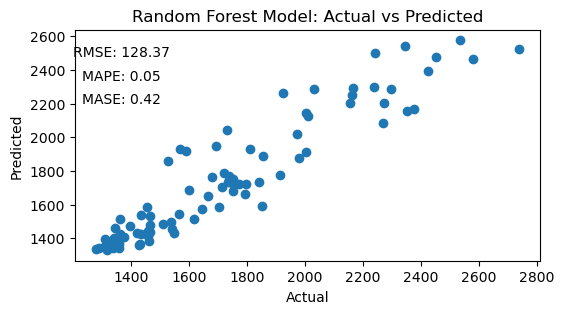

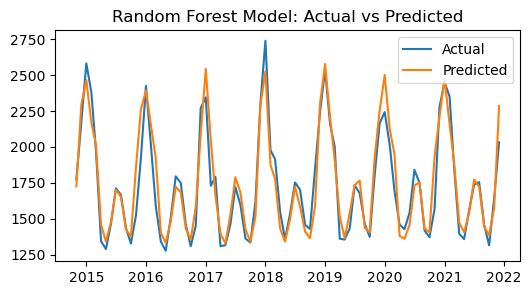

In [101]:
result=fit_one_step_reg_model(energy_train, energy_test, regressor=Random_Forest , target_variable='E_consumption')

In [102]:
result[1].feature_importances_

# present feature importance with feature names as df
feature_importance = pd.DataFrame(result[1].feature_importances_, index=energy_train.drop(columns='E_consumption').columns, columns=['Importance'])
feature_importance.sort_values(by='Importance', ascending=False)
feature_importance


,Importance
Lag1,0.02
Lag2,0.01
Lag3,0.01
Lag4,0.00
Lag5,0.02
Lag6,0.01
Lag7,0.00
Lag8,0.01
Lag9,0.00
Lag10,0.01


### Multi-step forecasting
- predict a series of muliple future step ( 𝑋𝑋11 , 𝑋𝑋12, 𝑋𝑋13 ) based on a sequence of X laged values.

#### Model Functions

In [103]:
# function split the data into train and test sets chronologically
def split_train_test_by_rows(df, test_rows=20):
    n = test_rows 
    train, test = df[:-n], df[-n:]
    return train, test

In [104]:
def prepare_train_test_data(time_series_df, test_rows_len=20):
    
    # Split the data into training and testing sets
    ts_train, ts_test = split_train_test_by_rows(time_series_df, test_rows=test_rows_len)
    target_variable = time_series_df.columns[0]

    print(f'Train shape: {ts_train.shape}, Test shape: {ts_test.shape} \nTarget variable: {target_variable}')

    # Separate the features and target variable for both training and testing sets
    X_train, y_train = ts_train.drop(columns=[target_variable]), ts_train[target_variable]
    X_test, y_test = ts_test.drop(columns=[target_variable]), ts_test[target_variable]

    return X_train, y_train, X_test, y_test, target_variable

In [105]:
def multi_step_forecast_recursive(start_row, model, steps=10):
    forecast = []
    data = start_row.values[0] # get the first row of the test data as initia X
    for i in range(steps):
        one_step_pred = model.predict(data.reshape(1, -1)) # predict the next time step 
        forecast.append(one_step_pred[0]) # append the prediction to the forecast list
        data = np.roll(data, shift=1) # shift the data by one step
        data[0] = one_step_pred # place the one step prediction in the first column (lag 1) of the X data
    return np.array(forecast)

In [106]:
def plot_and_evaluate(y_test, forecast, y_train, reg_model, target_variable):
    # Create a new DataFrame with the forecasted values as y_pred and the y_test values as y_true
    forecast_df = pd.DataFrame({'y_true': y_test.values, 'y_pred': forecast})
    # Set the index of the forecast_df to the index of the y_test
    forecast_df.index = y_test.index

    # Calculate evaluation metrics
    rmse_test = np.sqrt(mse(forecast_df['y_true'], forecast_df['y_pred']))
    mape_test = mape(forecast_df['y_true'], forecast_df['y_pred'])
    mase_test = mase(forecast_df['y_true'], forecast_df['y_pred'], y_train=y_train)

    # Plot the actual vs predicted values
    plt.figure(figsize=(8, 3))
    plt.plot(forecast_df.index, forecast_df['y_true'], label='Actual')
    plt.plot(forecast_df.index, forecast_df['y_pred'], label='Predicted')
    plt.legend()
    plt.title(f'Multi-step Forecast: {target_variable}')
    plt.show()

    # Print the evaluation metrics
    print(f'Model: {reg_model[1]}, Prediction: {target_variable}')
    print(f'RMSE: {rmse_test:.2f}')
    print(f'MAPE: {mape_test:.2f}')
    print(f'MASE: {mase_test:.2f}')
    

In [107]:
# initialize the basic regression models- Regressors
Linear_Regression = (LinearRegression(), 'Linear Regression') 
Ridge_Regression = (Ridge(alpha=0.5) , 'Ridge Regression')
Lasso_Regression = (Lasso(alpha=0.5) , 'Lasso Regression')
Random_Forest = (RandomForestRegressor(), 'Random Forest')

# create a list of the regressors for comparison
regressors_list = [Linear_Regression, Ridge_Regression, Lasso_Regression, Random_Forest]

#### Fit Model and creat Multi-step Prediction

##### Linear_Regression

Train shape: (490, 13), Test shape: (86, 13) 
Target variable: E_consumption


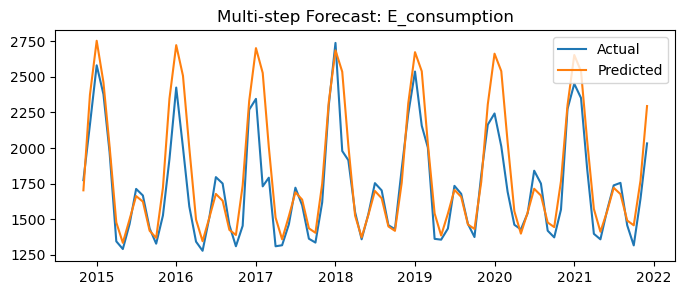

Model: Linear Regression, Prediction: E_consumption
RMSE: 198.19
MAPE: 0.07
MASE: 0.59


In [108]:
#  Select the data set to use
time_sereis_df = energy_lags
X_train, y_train, X_test, y_test, target_variable = prepare_train_test_data(time_sereis_df, test_rows_len=86) # prepare the data for training and testing the model

# Select the regression model to use
reg_model= Linear_Regression

model=reg_model[0] # get the model from the tuple
model.fit(X_train, y_train) # fit the model on the training data

start_row= X_test.head(1) # get the first row of the test data as the starting point for the forecast
pred_steps= len(y_test) # set the number of steps to forecast to the length of the test data

forecast=multi_step_forecast_recursive(start_row, model=model, steps=pred_steps) # forecast the next chosen number of steps

plot_and_evaluate(y_test, forecast, y_train, reg_model, target_variable) # plot the forecasted vs actual values and evaluate the model results


##### Random_Forest

Train shape: (490, 13), Test shape: (86, 13) 
Target variable: E_consumption


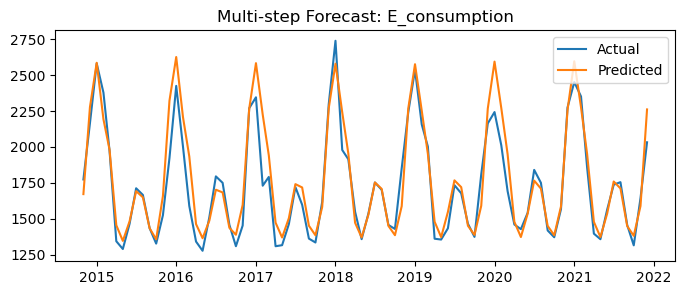

Model: Random Forest, Prediction: E_consumption
RMSE: 134.07
MAPE: 0.05
MASE: 0.41


In [109]:
#  Select the data set to use
time_sereis_df = energy_lags
X_train, y_train, X_test, y_test, target_variable = prepare_train_test_data(time_sereis_df, test_rows_len=86) # prepare the data for training and testing the model

# Select the regression model to use
reg_model= Random_Forest

model=reg_model[0] # get the model from the tuple
model.fit(X_train, y_train) # fit the model on the training data

start_row= X_test.head(1) # get the first row of the test data as the starting point for the forecast
pred_steps= len(y_test) # set the number of steps to forecast to the length of the test data

forecast=multi_step_forecast_recursive(start_row, model=model, steps=pred_steps) # forecast the next chosen number of steps

plot_and_evaluate(y_test, forecast, y_train, reg_model, target_variable) # plot the forecasted vs actual values and evaluate the model results

#### Evaluate Over fitting
- Predict values based on the train set and compare prediction accuracy to the test set
- Try adjusting model prameters to effect overfiiting and generalize the model

### Optimizing a model with hyperparameter tuning
- Use grid search or grid search CV

### Additional Knowledg- Forecasting using dedicated libarary for time series- SKtime
- A framework to create a ML pipeline that prepares  time series data and can use algorithms from a standard ML library such as sklearn.
- Has functionlity for data preparation, model training, forecasting, and evaluating model performance
- For example: TransformedTargetForecaster class apply a set of transformation. Detrender and Deseasonalizer classes removes trend and seasonality.
- the make_reduction function is comparable to the one_step_forecast and the multi_step_forecast functions we created earlier. you can choose strategyfor multi-step time series forecasting: direct (default), recursive, or multioutput
- See more about SKtime functionality in chapter 12 of Time Series Cookbook or visit the SKtime documentation page.

# Section 2- Unsupervised Machine Learning for Anomaly Detection (Outlier Detection)

We implememnt models from the PyOD library, a Python package that offers an extensive collection of algorithms for detecting anomalous / outlying objects in multivariate data.
read more- https://pyod.readthedocs.io/en/latest/

## Load data

In [110]:
# load data set of ny taxi rides, the value is the number of taxi rides in 30 minutes
local_path = 'Data_sets/nyc_taxi.csv'
nyc_taxi = pd.read_csv(local_path, index_col='timestamp', parse_dates=True)
nyc_taxi.index.freq = '30T'  # Set the frequency of the index to 30 minutes
print(nyc_taxi.info())

# creat a date set of daily taxi rides
nyc_taxi_daily = nyc_taxi.resample('D').sum()
nyc_taxi_daily.index.freq = 'D'  # Set the frequency of the index to daily
print(nyc_taxi_daily.info())



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10320 entries, 2014-07-01 00:00:00 to 2015-01-31 23:30:00
Freq: 30min
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   10320 non-null  int64
dtypes: int64(1)
memory usage: 161.2 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215 entries, 2014-07-01 to 2015-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   215 non-null    int64
dtypes: int64(1)
memory usage: 3.4 KB
None


In [114]:
# known dates containing outliers to be used as ground truth labels
nyc_known_outliers_dates =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]

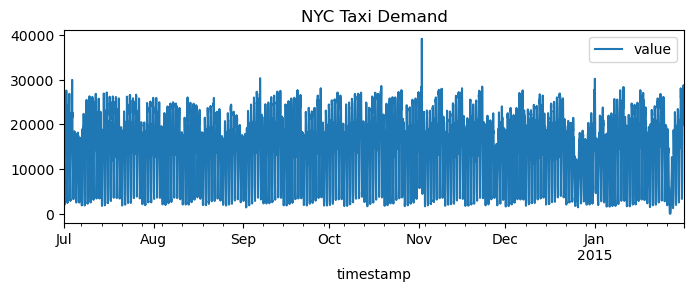

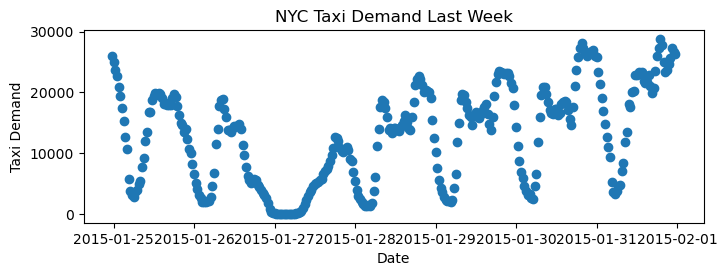

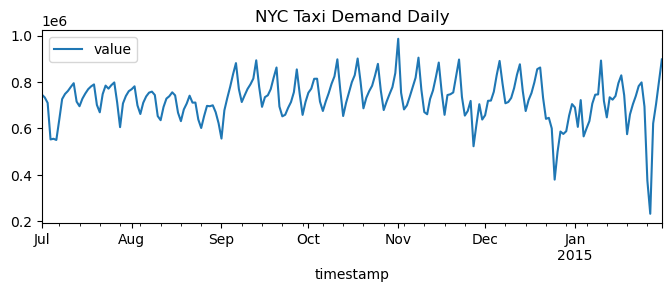

In [112]:
# plot the data
nyc_taxi.plot(figsize=(8, 2.5))
plt.title('NYC Taxi Demand')
plt.show()

# select the last 7 days of the data
last_day= nyc_taxi.index[-1]
nyc_taxi_last_week = nyc_taxi[last_day - pd.Timedelta(days=7):last_day]
# plot the data as scatter plot
plt.figure(figsize=(8, 2.5))
plt.scatter(nyc_taxi_last_week.index, nyc_taxi_last_week['value'])
plt.title('NYC Taxi Demand Last Week')
plt.xlabel('Date')
plt.ylabel('Taxi Demand')
plt.show()

# plot the daily data
nyc_taxi_daily.plot(figsize=(8, 2.5))
plt.title('NYC Taxi Demand Daily')
plt.show()

## Functiones

Number of data points 215
Number of outliers =  6
             value
timestamp         
2014-11-01  986568
2014-11-27  523184
2014-12-25  379302
2014-12-26  499102
2015-01-26  375311
2015-01-27  232058


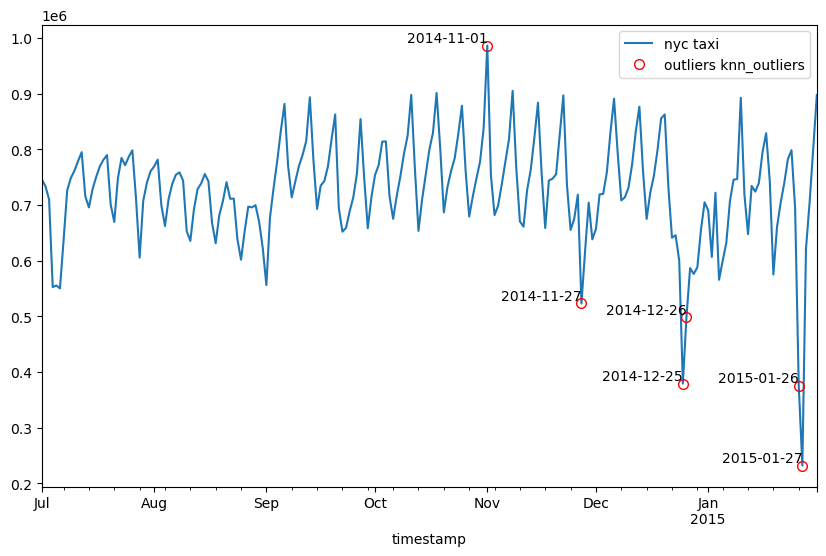

In [129]:
def plot_outliers(outliers, data, method, labels=True, plot_known=False, known_outliers=known_outliers, halignment='right', valignment='bottom'):
    fig, ax = plt.subplots(figsize=(10, 6))
    data.plot(ax=ax)
    outliers.plot(ax=ax, marker='o', markerfacecolor='none', markeredgecolor='r', linestyle='none', markersize=7)
    plt.legend(['nyc taxi', f'outliers {method}'])
    
    if plot_known and known_outliers is not None:
        data.loc[known_outliers.index].plot(ax=ax, marker='o', markerfacecolor='none', markeredgecolor='g', linestyle='none', markersize=7)
        plt.legend(['nyc taxi', f'outliers {method}', 'known outliers'])
    
    if labels:
        for i in outliers.index:
            ax.text(i, outliers.loc[i], str(i.date()), horizontalalignment=halignment, verticalalignment=valignment)
    
    plt.show()

# Example usage
predicted = pd.Series(knn.predict(nyc_taxi_daily), index=nyc_taxi_daily.index)
print('Number of data points', len(nyc_taxi_daily))
print('Number of outliers = ', predicted.sum())
knn_outliers = nyc_taxi_daily.loc[predicted == 1]
print(knn_outliers)
plot_outliers(knn_outliers, nyc_taxi_daily, 'knn_outliers', labels=True)

In [177]:
def plot_outliers(outliers, data, method='',labels=False, plot_known=True, known_outliers = nyc_known_outliers_dates, halignment = 'right', valignment = 'top'):

    ax = data.plot(alpha=0.6)
    
    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'v', markersize=8, markerfacecolor='none', markeredgecolor='k')
            plt.text(i[0], i[1]-(i[1]*0.04), f'{i[0].strftime("%m/%d")}', 
                         horizontalalignment=halignment,
                         verticalalignment=valignment)
    else:
        data.loc[outliers.index].plot(ax=ax, style='rx', markersize=9)

    plt.legend(['nyc taxi',f'outliers {method}'])


    if plot_known: 
        # plot known outliers on top of the data
        known_outliers = data.loc[nyc_known_outliers_dates]
        known_outliers.plot(ax=ax, style='g.', markersize=9)
        
        plt.legend(['nyc taxi',f'outliers {method}','known outliers'])
        
    plt.title(f'NYC Taxi - {method}')
    plt.gcf().set_size_inches(8, 3)
    plt.xlabel('date'); plt.ylabel('Number of passengers')
    
    plt.show()

### Visualize known outliers

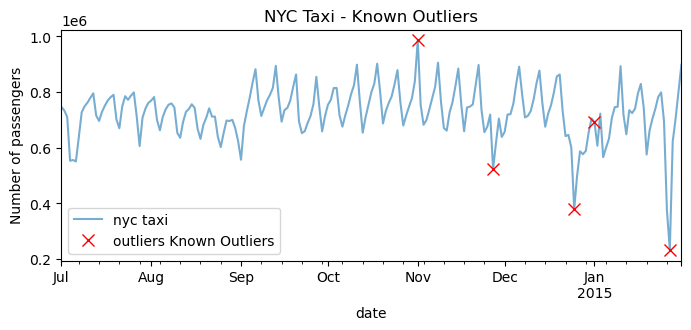

In [165]:
known_outliers = nyc_taxi_daily.loc[nyc_known_outliers_dates]
plot_outliers(known_outliers, nyc_taxi_daily, 'Known Outliers', plot_known=False)

## KNN: K Nearest Neighbors

- KNN is used in an unsupervised learning manner
- the algorithm finds the closest K nearest neighbors for every data point
- the distance becomes the score to determine which points are outliers among the population
- in this scenario KNN is a proximity-based algorithm
-
- Parameters:
- K- the number of nearest neighbors, a parameter we need to determine (default n_neighbors=5)
- Contamination, a numeric (float) value ranging from 0 to 0.5 (defaules=0.1) representing the expectation of the dataset's fraction of outliers. This is a common parameter across all the different classes (algorithms) in PyOD. 
- Method ('largest', 'mean', 'median'), how the distance to the neighboring group is valued (default='largest'), we will use 'mean'- the average of all k neighbor distances.
- The Predict method will generate binary labels (1 or 0) for each data point, 1 indicates an outlier

In [136]:
from pyod.models.knn import KNN

In [137]:
knn = KNN(contamination=0.03, method='mean', n_neighbors=5)
knn.fit(nyc_taxi_daily)

KNN(algorithm='auto', contamination=0.03, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [151]:
nyc_taxi_daily.loc[known_outliers.index]

,value
timestamp,
2014-11-01,986568
2014-11-27,523184
2014-12-25,379302
2015-01-01,690407
2015-01-27,232058


Number of data points 215
Number of outliers =  6
             value
timestamp         
2014-11-01  986568
2014-11-27  523184
2014-12-25  379302
2014-12-26  499102
2015-01-26  375311
2015-01-27  232058


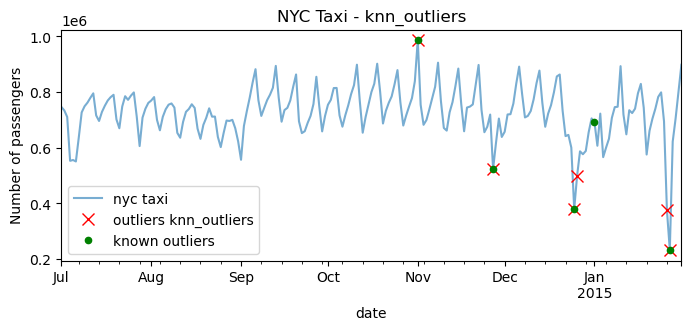

In [178]:
predicted = pd.Series(knn.predict(nyc_taxi_daily), index=nyc_taxi_daily.index)
print('Number of data points', len(nyc_taxi_daily))
print('Number of outliers = ', predicted.sum())
knn_outliers = nyc_taxi_daily.loc[predicted == 1]
print(knn_outliers) 
plot_outliers(knn_outliers, data= nyc_taxi_daily, method='knn_outliers',labels=False, plot_known=True)

PyOD will determine a threshold distance value ('score') to limit the number of outliers returned. The threshold value depends on the contamination ratio you
provided earlier (the proportion of outliers you suspect).

### Score and Treshold defenitions

In [168]:
knn_scores = knn.decision_scores_
knn_scores_df = (pd.DataFrame(knn_scores, index=nyc_taxi_daily.index, columns=['score']))
knn_scores_df = knn_scores_df.sort_values(by='score', ascending=False)
knn_scores_df




,score
timestamp,
2015-01-27,233378.80
2015-01-26,118776.40
2014-12-25,117180.00
2014-11-01,86728.80
2014-12-26,48461.60
...,...
2014-09-09,654.60
2014-10-15,654.00
2014-10-01,654.00


In [169]:
print('\n Treshold:', knn.threshold_)
knn_scores_df[knn_scores_df['score'] >= knn.threshold_].sort_values('score', ascending=False)


 Treshold: 10800.859999999999


,score
timestamp,
2015-01-27,233378.80
2015-01-26,118776.40
2014-12-25,117180.00
2014-11-01,86728.80
2014-12-26,48461.60
2014-11-27,29196.00
2014-09-27,10829.00


In [170]:
contamination=0.03
cut_off = int(len(nyc_taxi_daily) * contamination)
knn_outliers_cutoff= knn_scores_df.nlargest(cut_off+1, 'score')

print('cut_off number:', cut_off)
print(knn_outliers_cutoff)


cut_off number: 6
               score
timestamp           
2015-01-27 233378.80
2015-01-26 118776.40
2014-12-25 117180.00
2014-11-01  86728.80
2014-12-26  48461.60
2014-11-27  29196.00
2014-09-27  10829.00


### Visualize Score and Treshold

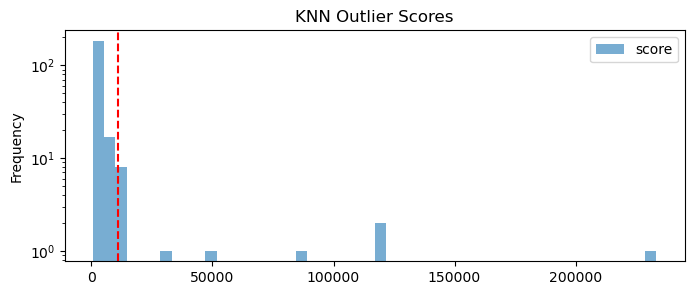

In [171]:
# hist of the scores
knn_scores_df.plot.hist(bins=50, alpha=0.6, title='KNN Outlier Scores', figsize=(8, 3))
#set x axis log scale
plt.yscale('log')
# plot the treshold as a vertical dashed line
plt.axvline(knn.threshold_, color='r', linestyle='--')

### Outliers probability score
- Returns the probability of being normal and the probability of being abnormal for each observation
- the 'linear' method uses MinMaxScaler from scikit-learn to scale the scores and for calculating the probabilities
- The 'unify' method uses the z-score standardization and the Gaussian error function (ERF) from the SciPy library

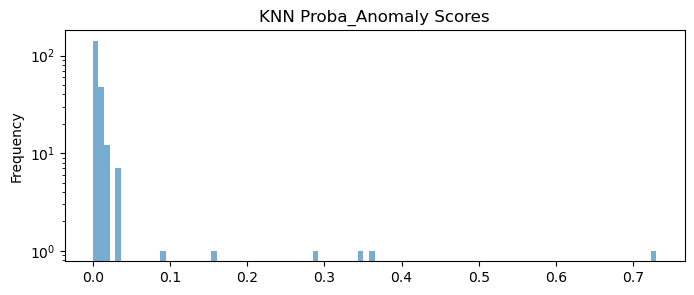

,Proba_Normal,Proba_Anomaly
timestamp,,
2015-01-27,0.27,0.73
2015-01-26,0.64,0.36
2014-12-25,0.65,0.35
2014-11-01,0.71,0.29
2014-12-26,0.84,0.16
...,...,...
2014-09-22,1.00,0.00
2014-09-23,1.00,0.00
2014-09-25,1.00,0.00


In [172]:
knn_proba = knn.predict_proba(nyc_taxi_daily, method='linear')
knn_proba_df = (pd.DataFrame(np.round(knn_proba, 2), index=nyc_taxi_daily.index, columns=['Proba_Normal', 'Proba_Anomaly']))
# hist of the scores
knn_proba_df['Proba_Anomaly'].plot.hist(bins=100, alpha=0.6, title='KNN Proba_Anomaly Scores', figsize=(8, 3))
plt.yscale('log')
plt.show()
knn_proba_df.sort_values('Proba_Anomaly', ascending=False)

#### Determine outlieres by Anomaly Proba

Number of outliers: 5


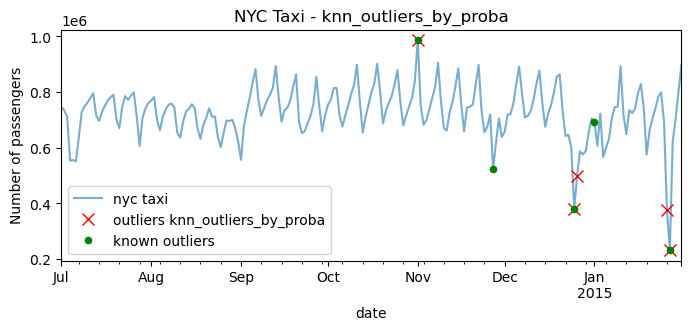

In [179]:
# determine the threshold for the Proba_Anomaly
proba_treshold= 0.1
# select the outliers
knn_proba_outliers = knn_proba_df[knn_proba_df['Proba_Anomaly'] >= proba_treshold]
print('Number of outliers:', len(knn_proba_outliers))
plot_outliers(knn_proba_outliers, nyc_taxi_daily, 'knn_outliers_by_proba',labels=False, plot_known=True)



## Local Outlier Factor (LOF)

- LOF is considered a density-based algorithm.  
- Suitable for identifying outliers on their local region rather than from the global distribution
- Idea behind LOF is that outliers will be isolated, and thus will be in low-density regions
- It computes the "local density" of each data point by calculating the distance to the K nearest neighbors (like KNN), then the Outlier Score is calculated as the ratio of the "local density" of a point to the "local densities" of its neighbors. 
- A score significantly greater than 1 indicates the point is an outlier.
- LOF works well with high-dimensional (multivariate) data 

In [180]:
from pyod.models.lof import LOF

In [181]:
lof = LOF(contamination=0.05, n_neighbors=10)
lof.fit(nyc_taxi_daily)

LOF(algorithm='auto', contamination=0.05, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=10, novelty=True, p=2)

Number of data points 215
Number of outliers =  8
             value
timestamp         
2014-09-27  854486
2014-11-01  986568
2014-11-27  523184
2014-12-19  855719
2014-12-25  379302
2014-12-26  499102
2015-01-26  375311
2015-01-27  232058


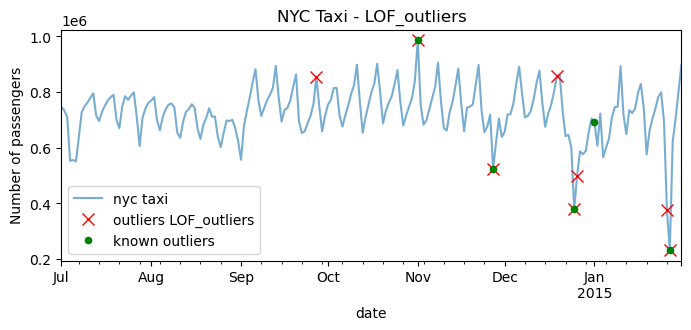

In [183]:
predicted = pd.Series(lof.predict(nyc_taxi_daily), index=nyc_taxi_daily.index)
print('Number of data points' , len(nyc_taxi_daily))
print('Number of outliers = ', predicted.sum())
lof_outliers = nyc_taxi_daily.loc[predicted == 1]
print(lof_outliers) 
plot_outliers(lof_outliers, nyc_taxi_daily, 'LOF_outliers',labels=False)

### LOF score 

In [184]:
lof_scores = lof.decision_scores_
lof_scores_df = (pd.DataFrame(lof_scores, index=nyc_taxi_daily.index, columns=['score'])).sort_values('score', ascending=False)
print(lof_scores_df)
print('\n threshold_',lof.threshold_)


            score
timestamp        
2015-01-27   5.79
2014-11-01   4.89
2015-01-26   3.76
2014-12-25   3.71
2014-12-26   1.89
...           ...
2015-01-18   0.95
2014-09-25   0.93
2014-09-08   0.93
2014-09-30   0.93
2014-12-09   0.93

[215 rows x 1 columns]

 threshold_ 1.2831183678575053


## Isolation Forest (iForest)

- Isolation Forest focuses on isolating outliers from the rest of the points
- The algorithm randomly chooses a split value and then recursively spliting the data until all 
points belong to a partition
- Outliers are expected to be isolated faster (fewer random splits) since they lie far from other data points 
- iForest is an ensemble learning method.it draws a random sample from the main data set to train a weak estimator (a tree) and repeats the process multiple time to creat the entire model (the forest)
- Each data point is assigned an anomaly score based on how early in the partitioning process it gets isolated
- Isolation Forest model can be apliied directly for multivariate time series

In [185]:
from pyod.models.iforest import IForest

In [186]:
iforest = IForest(contamination=0.03, n_estimators=100, random_state=123, bootstrap=True)
iforest.fit(nyc_taxi_daily)
predicted = pd.Series(iforest.predict(nyc_taxi_daily), index=nyc_taxi_daily.index)
print('Number of outliers = ', predicted.sum())

Number of outliers =  7


Number of data points 215
Number of outliers =  7
             value
timestamp         
2014-11-01  986568
2014-11-08  905152
2014-11-27  523184
2014-12-25  379302
2014-12-26  499102
2015-01-26  375311
2015-01-27  232058


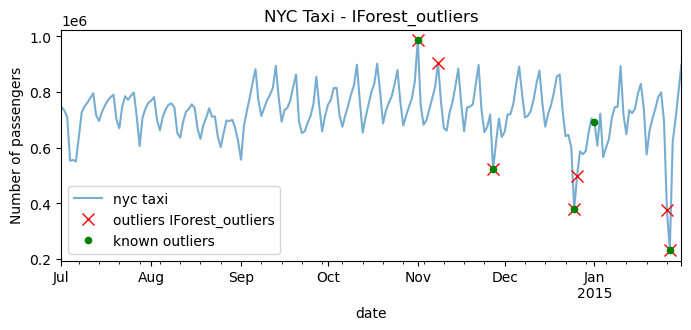

In [187]:
predicted = pd.Series(iforest.predict(nyc_taxi_daily), index=nyc_taxi_daily.index)
print('Number of data points' , len(nyc_taxi_daily))
print('Number of outliers = ', predicted.sum())
iforest_outliers = nyc_taxi_daily.loc[predicted == 1]
print(iforest_outliers) 
plot_outliers(iforest_outliers, nyc_taxi_daily, 'IForest_outliers',labels=False)

In [188]:
iforest_scores = iforest.decision_scores_
iforest_scores_df = (pd.DataFrame(iforest_scores,  index=nyc_taxi_daily.index, columns=['score'])).sort_values('score', ascending=False)
iforest_scores_df

,score
timestamp,
2015-01-27,0.19
2015-01-26,0.12
2014-12-25,0.12
2014-11-01,0.11
2014-12-26,0.08
...,...
2014-11-19,-0.22
2015-01-09,-0.22
2014-10-29,-0.22


In [189]:
iforest.threshold_

-1.8648277366750676e-16

In [190]:
outliers_scores= iforest_scores_df[iforest_scores_df['score'] >= iforest.threshold_]
outliers_scores

,score
timestamp,
2015-01-27,0.19
2015-01-26,0.12
2014-12-25,0.12
2014-11-01,0.11
2014-12-26,0.08
2014-11-27,0.05
2014-11-08,0.01


 ## Additional Anomaly Detection Models

### One-Class Support Vector Machine (OCSVM)

- Support Vector Machine (SVM) algorithm, in its unsupervised manner, tries to find a boundary (hyperplane) in the feature space that separates the normal data points from outliers
- OCSVM assumes that the majority of the data points are normal, and it tries to learn a region in the feature space where most of the data resides
- Points that fall outside this learned region are classified as anomalies
- Kernel Trick: OCSVM can use different kernels functions (linear, radial, polynomial) to find complex and non-linear boundaries in the data
- For SVM it is crusial that data is properly normalized, especially when working with multidimensional features

Key Parameters:
- kernel: Specifies the kernel type 'linear', 'rbf' (Radial Basis Function), or 'poly' (polynomial)
- nu:  controls the trade-off between the number of outliers and the decision function's margin. a smaller value of nu allows fewer outliers.



In [191]:
from pyod.models.ocsvm import OCSVM

Number of data points 215
Number of outliers =  2
             value
timestamp         
2014-08-17  667964
2015-01-31  897719


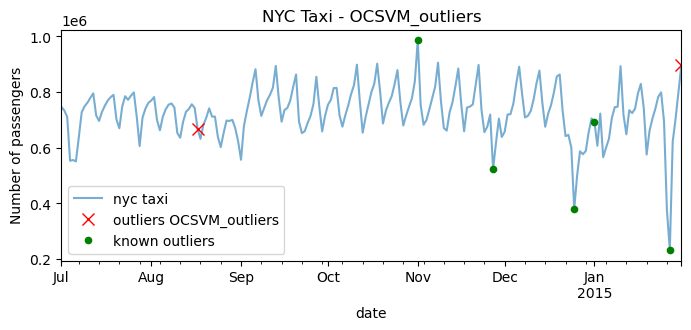

In [192]:
ocsvm = OCSVM(contamination=0.03, kernel='rbf', nu=0.9)
ocsvm.fit(nyc_taxi_daily)
predicted = pd.Series(ocsvm.predict(nyc_taxi_daily), index=nyc_taxi_daily.index)
print('Number of data points' , len(nyc_taxi_daily))
print('Number of outliers = ', predicted.sum())
ocsvm_outliers = nyc_taxi_daily.loc[predicted == 1]
print(ocsvm_outliers) 
plot_outliers(ocsvm_outliers, nyc_taxi_daily, 'OCSVM_outliers',labels=False)

#### Scale data to solve 

In [193]:
# scale the data
# scaler = StandardScaler()
scaler = MinMaxScaler()
nyc_taxi_daily_scaled = scaler.fit_transform(nyc_taxi_daily)
nyc_taxi_daily_scaled = pd.DataFrame(nyc_taxi_daily_scaled, index=nyc_taxi_daily.index, columns=nyc_taxi_daily.columns)




Number of data points 215
Number of outliers =  7
             value
timestamp         
2014-11-01  986568
2014-11-08  905152
2014-11-27  523184
2014-12-25  379302
2014-12-26  499102
2015-01-26  375311
2015-01-27  232058


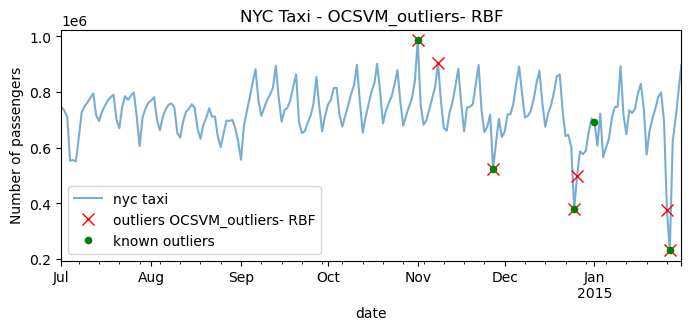

In [194]:
ocsvm = OCSVM(contamination=0.03, kernel='rbf')
ocsvm.fit(nyc_taxi_daily_scaled)
predicted = pd.Series(ocsvm.predict(nyc_taxi_daily_scaled), index=nyc_taxi_daily.index)
print('Number of data points' , len(nyc_taxi_daily))
print('Number of outliers = ', predicted.sum())
ocsvm_outliers = nyc_taxi_daily.loc[predicted == 1]
print(ocsvm_outliers) 
plot_outliers(ocsvm_outliers, nyc_taxi_daily, 'OCSVM_outliers- RBF',labels=False)

Number of data points 215
Number of outliers =  7
             value
timestamp         
2014-07-04  552565
2014-07-06  550285
2014-11-27  523184
2014-12-25  379302
2014-12-26  499102
2015-01-26  375311
2015-01-27  232058


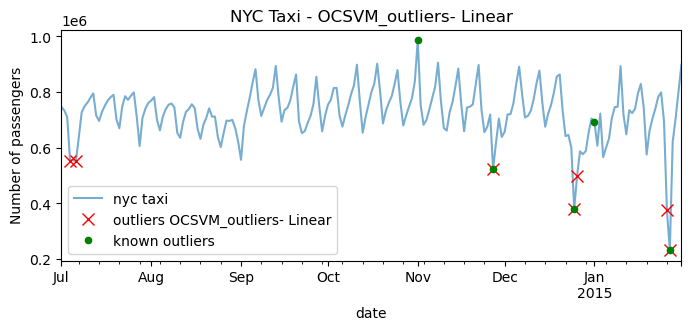

In [195]:
ocsvm = OCSVM(contamination=0.03, kernel='linear')
ocsvm.fit(nyc_taxi_daily_scaled)
predicted = pd.Series(ocsvm.predict(nyc_taxi_daily_scaled), index=nyc_taxi_daily.index)
print('Number of data points' , len(nyc_taxi_daily))
print('Number of outliers = ', predicted.sum())
ocsvm_outliers = nyc_taxi_daily.loc[predicted == 1]
print(ocsvm_outliers) 
plot_outliers(ocsvm_outliers, nyc_taxi_daily, 'OCSVM_outliers- Linear',labels=False)

Number of data points 215
Number of outliers =  7
             value
timestamp         
2014-07-04  552565
2014-07-06  550285
2014-11-27  523184
2014-12-25  379302
2014-12-26  499102
2015-01-26  375311
2015-01-27  232058


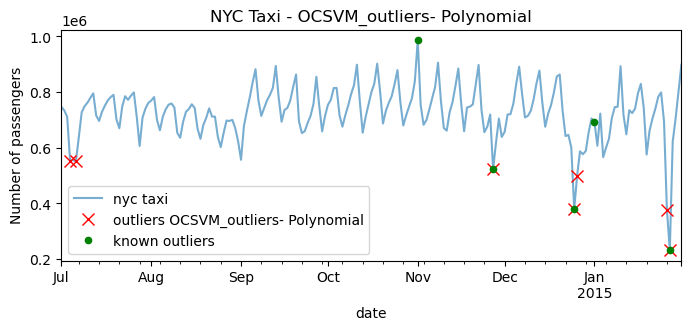

In [196]:
ocsvm = OCSVM(contamination=0.03, kernel='poly', degree=5, nu=0.9)
ocsvm.fit(nyc_taxi_daily_scaled)
predicted = pd.Series(ocsvm.predict(nyc_taxi_daily_scaled), index=nyc_taxi_daily.index)
print('Number of data points' , len(nyc_taxi_daily))
print('Number of outliers = ', predicted.sum())
ocsvm_outliers = nyc_taxi_daily.loc[predicted == 1]
print(ocsvm_outliers) 
plot_outliers(ocsvm_outliers, nyc_taxi_daily, 'OCSVM_outliers- Polynomial',labels=False)

### COPOD - Copula-Based Outlier Detection

- A new (2021) and simple algorithm based on the concept of Copulas, a statistical tool used to describe the dependenceis between random variables
- COPOD is a non-parametric method, meaning it does not make any assumptions about the underlying data distribution
- COPOD is computationally efficient and easy to implement, with no need for hyperparameter tuning
- COPOD works well with multivariate data and can capture complex dependencies between variables

In [197]:
from pyod.models.copod import COPOD

Number of data points 215
Number of outliers =  7
             value
timestamp         
2014-07-04  552565
2014-07-06  550285
2014-11-27  523184
2014-12-25  379302
2014-12-26  499102
2015-01-26  375311
2015-01-27  232058


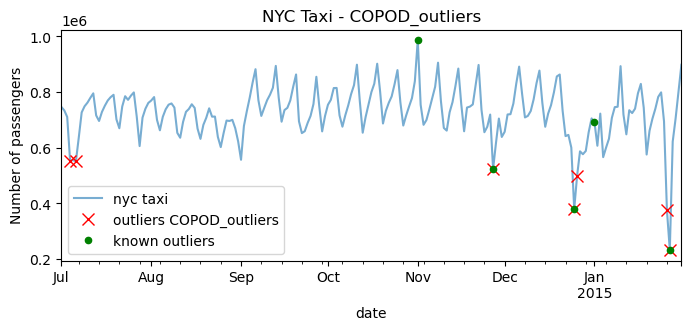

In [198]:
copod = COPOD(contamination=0.03)
copod.fit(nyc_taxi_daily)
predicted = pd.Series(copod.predict(nyc_taxi_daily), index=nyc_taxi_daily.index)
print('Number of data points' , len(nyc_taxi_daily))
print('Number of outliers = ', predicted.sum())
copod_outliers = nyc_taxi_daily.loc[predicted == 1]
print(copod_outliers) 
plot_outliers(copod_outliers, nyc_taxi_daily, 'COPOD_outliers',labels=False)